In [125]:
import numpy as np
import matplotlib.pyplot as plt
import ot

import matplotlib
matplotlib.rc('xtick',labelsize = 20)
matplotlib.rc('ytick',labelsize = 20)

def ProximalPointOT(mu, nv, C, beta = 2, maxiter = 1000, inner_maxiter = 1, use_path = True, return_map = True, return_loss = True):
    n = len(mu)
    a = np.ones([n,])
    b = a
    T = np.ones((n,n))/n**2
    G = np.exp(-(C/beta))
    loss = []
    for outer_iter in range(maxiter):
        Q = G * T
        for inner_iter in range(inner_maxiter):
            a = mu/(np.matmul(Q,b) + 1e-3)
            b = nv/(np.matmul(np.transpose(Q),a) + 1e-3)
        T = np.expand_dims(a,axis = 1)*Q*np.expand_dims(b,axis = 0)
        WD = np.sum(T*C)
        loss.append(WD)
    return T,loss

np.random.seed(123456)

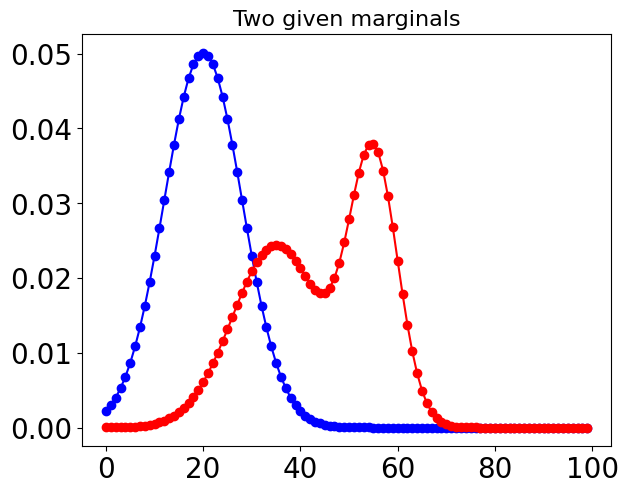

/home/ljb/miniforge3/envs/sbp/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Casting input data from float128 to float64 for imshow.
  fig.canvas.print_figure(bytes_io, **kw)


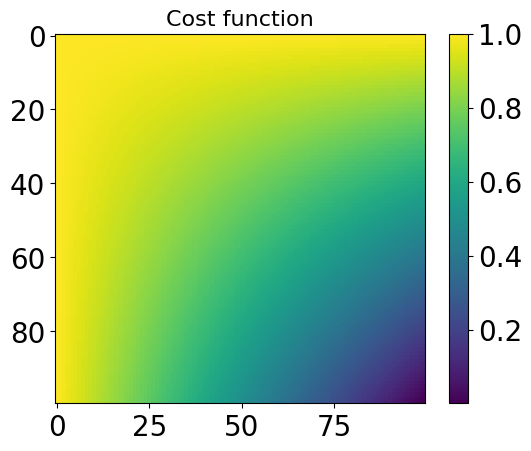

0.0
0.0
1.4982400621768755696e-1071
0.91986448380035730087


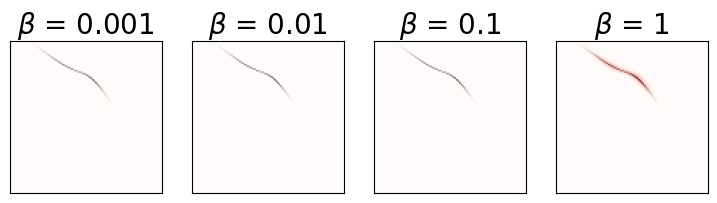

done


In [126]:
## numerical expertiments
colors=['k','b','g','r']

n = 100
x = np.arange(n,dtype = np.float128)

p1 = ot.datasets.get_1D_gauss(n,20,8)#0.55 * ot.datasets.get_1D_gauss(n,20,8) + 0.45 * ot.datasets.get_1D_gauss(n,70,9)
p2 = 0.55 * ot.datasets.get_1D_gauss(n,35,9) + 0.45 * ot.datasets.get_1D_gauss(n,55,5)

plt.plot(x,p1,'o-',color='blue')
plt.plot(x,p2,'o-',color='red')
plt.tight_layout()
plt.title('Two given marginals', fontsize=16)
plt.show()

# ## c = -xy
c = -x*np.expand_dims(x,axis=1)
c =  c - c.min() + 10
c/=c.max()


# print(c)
plt.imshow(c)
plt.colorbar()
# plt.clim(0, 1)
plt.title('Cost function', fontsize=16)
plt.show()

T_emd = ot.emd(p1,p2,c)
ground_truth = np.sum(T_emd*c)

maxiter = 2000
beta_list = [0.001,0.01,0.1,1]
inner_maxiter = 1
use_path = True

### proximal point OT
T_pp_list  = []
loss_pp_list = []

for beta in beta_list:
    # T, loss = fpot.fpot_wd(p1, p2, C, beta=beta, maxiter=maxiter, inner_maxiter=inner_maxiter, use_path=use_path)
    T,loss = ProximalPointOT(p1,p2,c,beta = beta, maxiter = maxiter, inner_maxiter = inner_maxiter, use_path = use_path)
    print(T.sum())
    loss_pp_list.append(loss)
    T_pp_list.append(T)
### colormap
import matplotlib.colors as colors
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap
cmap = plt.get_cmap('Reds')
new_cmap = truncate_colormap(cmap, 0., 0.8)


f,axarr = plt.subplots(1,len(beta_list),figsize = (9,3))
for i, beta in enumerate(beta_list):
    axarr[i].imshow(T_pp_list[i],cmap = new_cmap)
    axarr[i].imshow(T_emd,cmap = plt.get_cmap('binary'),alpha = 0.7)
    axarr[i].xaxis.set_ticks([])
    axarr[i].yaxis.set_ticks([])
    axarr[i].set_title(r'$\beta$ = ' + str(beta), fontsize = 20)
plt.show()

print('done')

# Wasserstein-SBP

$$
\begin{aligned}
\min _\gamma & \mathbb{E}_{\left(x_1, x_2, x_3, x_4\right) \sim \gamma}\left[d\left(\left(x_1, x_2\right),\left(x_3, x_4\right)\right)\right] \\
\text { s.t. } & \operatorname{Proj}_{1 \#} \gamma=\pi_1, \operatorname{Proj}_{2 \#} \gamma=\pi_2, \operatorname{Proj}_{3,4 \#} \gamma=\mathbb{Q}_0
\end{aligned}
$$

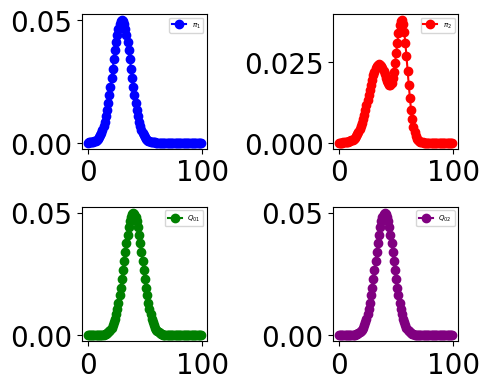

In [142]:

pi_1 = ot.datasets.get_1D_gauss(n,30,8)#0.55 * ot.datasets.get_1D_gauss(n,20,8) + 0.45 * ot.datasets.get_1D_gauss(n,70,9)
pi_2 = 0.55 * ot.datasets.get_1D_gauss(n,35,9) + 0.45 * ot.datasets.get_1D_gauss(n,55,5)

Q_01 = ot.datasets.get_1D_gauss(n,40,8)
Q_02 = ot.datasets.get_1D_gauss(n,40,8)

# Q_0 is the joint distribution of Q_01 and Q_02
Q_0 = np.outer(Q_01, Q_02)

fig, axs = plt.subplots(2, 2, figsize=(5, 4))
axs[0][0].plot(x, pi_1, 'o-', color='blue', label='$\pi_1$')
axs[0][1].plot(x, pi_2, 'o-', color='red', label='$\pi_2$')
axs[0][0].legend(fontsize=5)
axs[0][1].legend(fontsize=5)
fig.tight_layout()

axs[1][0].plot(x, Q_01, 'o-', color='green', label='$Q_{01}$')
axs[1][1].plot(x, Q_02, 'o-', color='purple', label='$Q_{02}$')
axs[1][0].legend(fontsize=5)
axs[1][1].legend(fontsize=5)
fig.tight_layout()

plt.show()

In [143]:
n = len(pi_1)

# 创建 x1 和 x3 的值
x1_values = np.arange(n,dtype=np.float128).reshape(n, 1)  # 转换为列向量
x3_values = np.arange(n,dtype=np.float128).reshape(1, n)  # 转换为行向量

# 使用 NumPy 的广播计算成本矩阵
c2 = -np.dot(x1_values, x3_values)
c2 = (c2 - c2.min())/(c2.max() - c2.min())

gamma_a,loss = ProximalPointOT(pi_1,Q_01,c2,beta=1,maxiter=2000,inner_maxiter=10)
gamma_a = (gamma_a - gamma_a.min())/(gamma_a.max() - gamma_a.min())
print(gamma_a.sum(),loss[-1])
gamma_b,loss = ProximalPointOT(Q_02,pi_2,c2,beta=1,maxiter=2000,inner_maxiter=10)
gamma_b = (gamma_b - gamma_b.min())/(gamma_b.max() - gamma_b.min())
print(gamma_b.sum(),loss[-1])

104.340023661989384954 0.8081144581545020593
128.36862517825646873 0.7454441284584605316


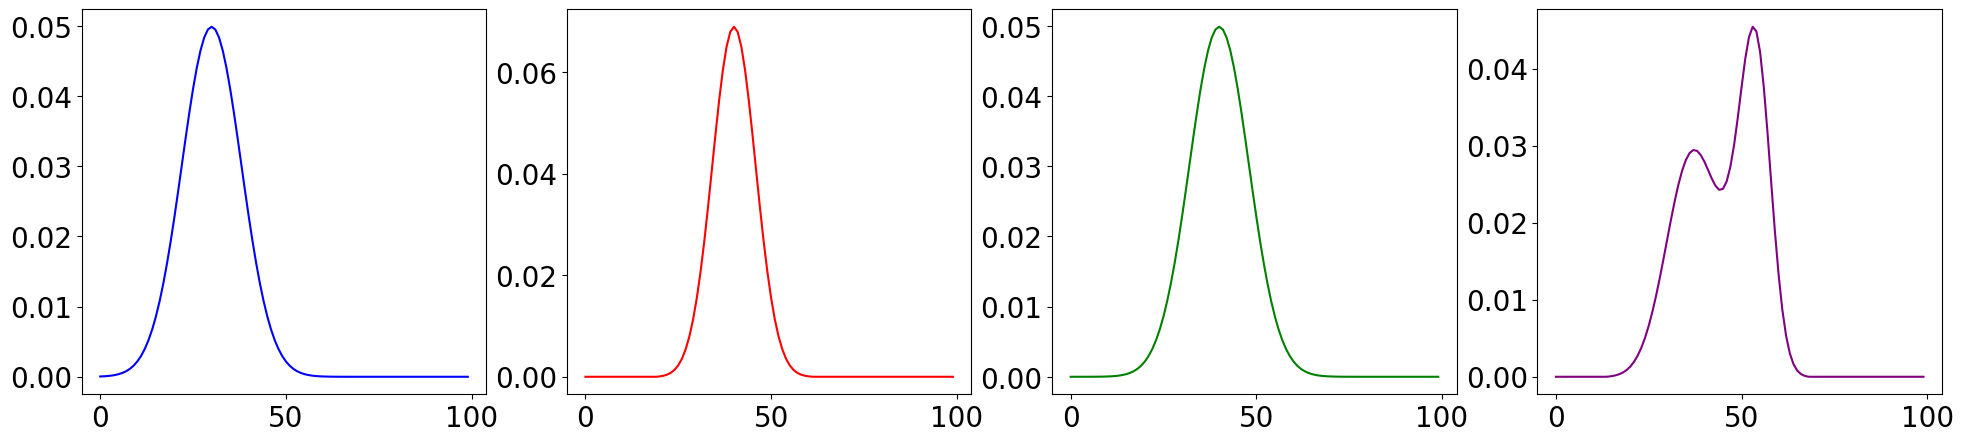

In [174]:

fig,axs = plt.subplots(1,4,figsize = (24,5))
axs[0].plot(x, pi_1, '-', color='blue', label='$\pi_1$')
cal_Q_01 = np.dot(pi_1, gamma_a)
cal_Q_01 = cal_Q_01 / cal_Q_01.sum()
axs[1].plot(x, cal_Q_01, '-', color='red', label='$Q_{01}$')
cal_Q_02 = np.dot(cal_Q_01,Q_0)
cal_Q_02 = cal_Q_02 / cal_Q_02.sum()
axs[2].plot(x, cal_Q_02, '-', color='green', label='$Q_{02}$')
cal_pi_2 = np.dot(cal_Q_02,gamma_b)
cal_pi_2 = cal_pi_2 / cal_pi_2.sum()
axs[3].plot(x, cal_pi_2, '-', color='purple', label='$\pi_2$')
fig.show()

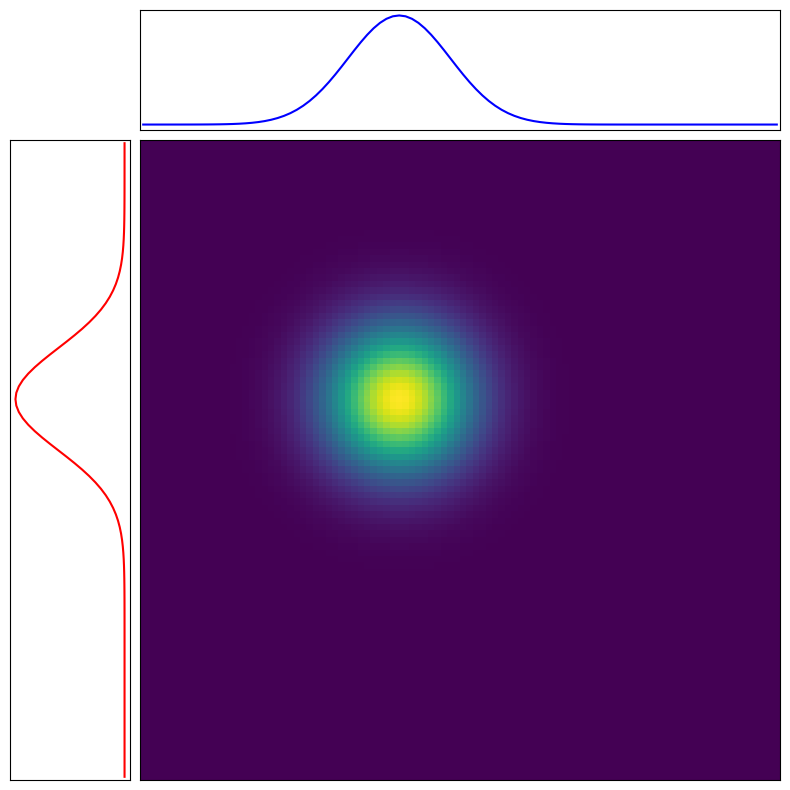

In [178]:
# 计算边缘分布
margin_x = Q_02  # y的边缘分布
margin_y = Q_01  # x的边缘分布

from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.figure(figsize=(10, 10))
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
divider = make_axes_locatable(ax)

# 创建额外的轴
ax_x = divider.append_axes("top", size=1.2, pad=0.1, sharex=ax)
ax_y = divider.append_axes("left", size=1.2, pad=0.1, sharey=ax)

# 热力图
cax = ax.imshow(Q_0,)

# 绘制边缘分布
ax_x.plot(range(n), margin_y, color='blue')
ax_y.plot(-margin_x, range(n), color='red')

# 设置轴的属性
ax_x.get_xaxis().set_visible(False)
ax_x.get_yaxis().set_visible(False)
ax_y.get_xaxis().set_visible(False)
ax_y.get_yaxis().set_visible(False)
ax.set_xticks(range(n))
ax.set_yticks(range(n))

plt.show()